# LASSO - least absolute shrinkage and selection operator

## LASSO of continous variables

Let's do variable selection of the six continous variables in the data set. I want to select the best three and expect that the model with these three variable performes better or at least not worse than the model with all six variabels.

Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is 

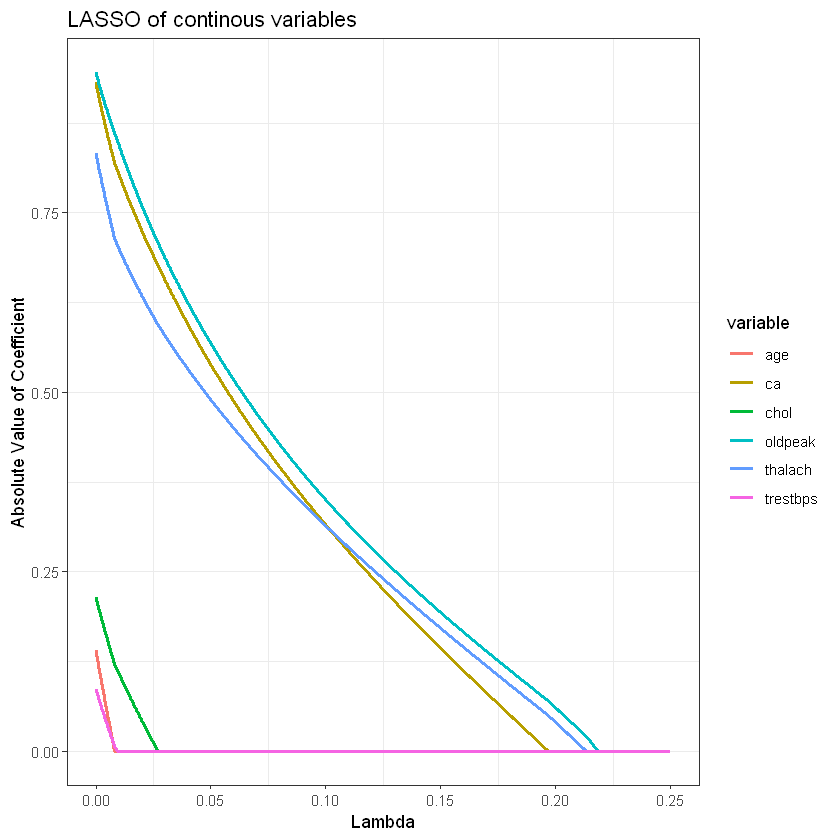

In [1]:
source("helpers.r")
library(tidyverse)
library(glmnet)

df <- get_training_df_clean()

arg <- preProcess(df, method=c("center", "scale"))
training_scaled <- predict(arg, df)

x <- model.matrix(target ~ age + thalach + trestbps + oldpeak + ca + chol, training_scaled)[,-1]
y <- ifelse(training_scaled$target == "no_disease", 0, 1)

lambdas = seq(0.25, 0, -0.0001)
fit <- glmnet(x, y, alpha = 1, family = "binomial", lambda = lambdas, standardize = FALSE)

coef <- as_tibble(as.matrix(fit$beta))
colnames(coef) = lambdas


coef <- coef %>% 
  add_column(variable = rownames(fit$beta))%>% 
  gather("lambda", "coef", -variable) %>% 
  mutate(lambda = as.numeric(lambda),
         coef = abs(coef))


ggplot(coef, aes(x = lambda, y = coef, color = variable)) +
  geom_line(size = 1) + 
  labs(
    x = "Lambda",
    y = "Absolute Value of Coefficient",
    title = "LASSO of continous variables"
  ) + 
  theme_bw() + 
  theme(panel.grid.major.x = element_blank(),
        plot.title = element_text(hjust = 0)
  ) 

See how nicely the first three variables approach towards zero. We can select these variables:

In [2]:
degrees_freedom <- coef %>% 
  group_by(lambda) %>%
  summarise(df = sum(coef > 0))

coef <- coef %>%
  left_join(degrees_freedom, by = "lambda")

coef %>%
  filter(df == 3 & coef != 0) %>%
  distinct(variable)

variable
thalach
oldpeak
ca


And finally compare the models:

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)
Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


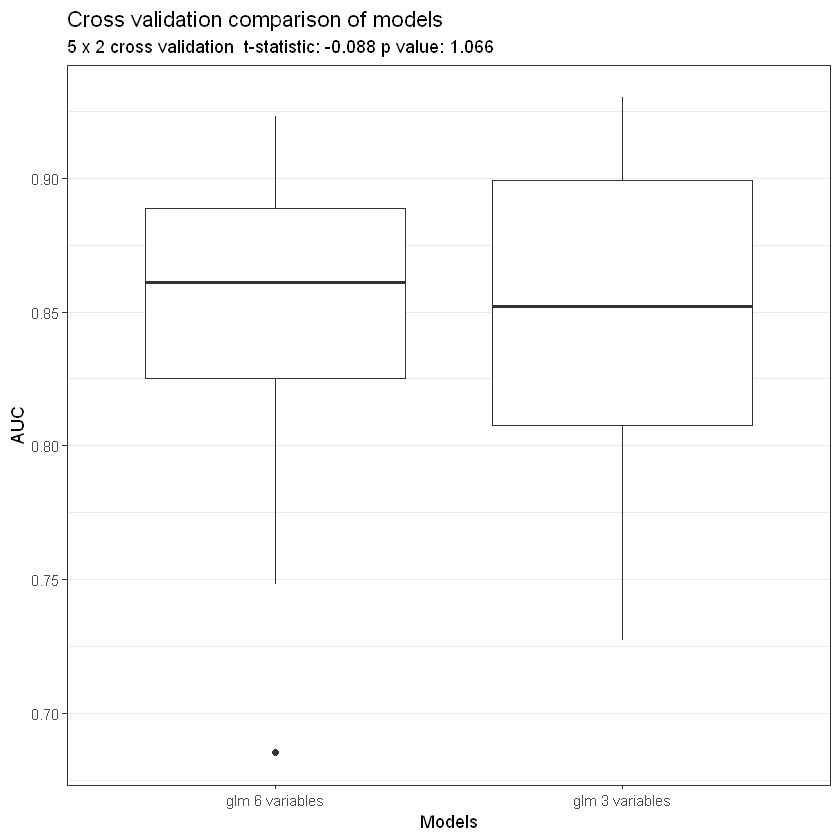

In [3]:
learner_A <- function(training, test) {
  name <- "glm 6 variables"
    
  fit <- glm(target ~ age + thalach + trestbps + oldpeak + ca + chol, data=training, family = binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

learner_B <- function(training, test) {   
  name <- "glm 3 variables"
    
  fit <- glm(target ~ thalach + oldpeak + ca, data=training, family = binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))

}


result <- cross_validation_selection(learner_A, learner_B)


plot_result(result)

Slightly but not significant worse ;) (and something is really wrong with the p value)

## LASSO with all variables

Now the same procedure with all variables. If one level of a categorial variable is not zero, i will inclue the variable.

In [4]:
 rm(list = ls())

source("helpers.r")
library(tidyverse)
library(glmnet)

df <- get_training_df_clean()

arg <- preProcess(df, method=c("center", "scale"))
training_scaled <- predict(arg, df)

x <- model.matrix(target ~ ., training_scaled)[,-1]
y <- ifelse(training_scaled$target == "no_disease", 0, 1)

lambdas = seq(0.25, 0, -0.0001)
fit <- glmnet(x, y, alpha = 1, family = "binomial", lambda = lambdas, standardize = FALSE)

coef <- as_tibble(as.matrix(fit$beta))
colnames(coef) = lambdas


coef <- coef %>% 
  add_column(variable = rownames(fit$beta))%>% 
  gather("lambda", "coef", -variable) %>% 
  mutate(lambda = as.numeric(lambda),
         coef = abs(coef))

degrees_freedom <- coef %>% 
  group_by(lambda) %>%
  summarise(df = sum(coef > 0))

coef <- coef %>%
  left_join(degrees_freedom, by = "lambda")

coef %>%
  filter(df == 6 & coef != 0) %>%
  distinct(variable)


Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


variable
thalach
oldpeak
ca
cpnon-anginal_pain
thalreversable_defect
thal?


Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)
Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


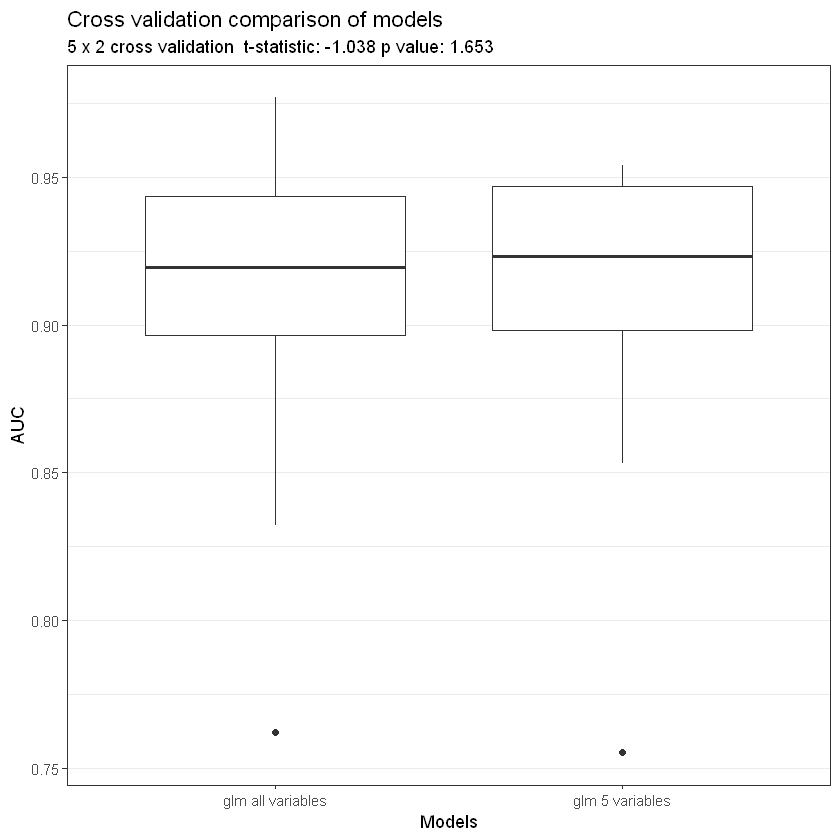

In [5]:
learner_A <- function(training, test) {
  name <- "glm all variables"
    
  fit <- glm(target ~ ., data=training, family = binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

learner_B <- function(training, test) {   
  name <- "glm 5 variables"
    
  fit <- glm(target ~ thalach + oldpeak + ca + cp + thal, data=training, family = binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))

}


result <- cross_validation_selection(learner_A, learner_B)


plot_result(result)

The result includes five variables, because there occoure two levels of `thal`. And here we are, the regularization yiels a bette model!